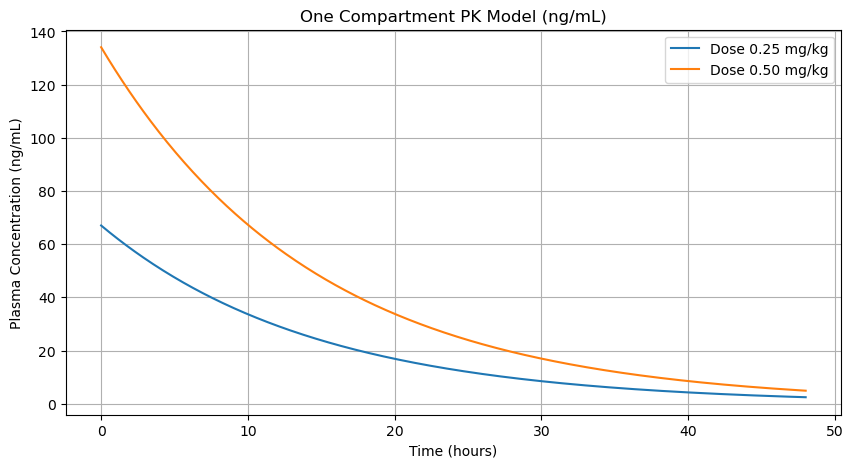

Initial concentration for 0.25 mg/kg dose: 67.02412868632707 ng/mL
Initial concentration for 0.50 mg/kg dose: 134.04825737265415 ng/mL
Max [Dn] (Bound dopamine): 0.0
Max [Dd] (Bound drug): 128.0535810350743
Max [Dm] (Bound metabolite): 0.0
Max [Dt] (Bound tracer): 0.0
Max [Dopamine levels]: 0.0


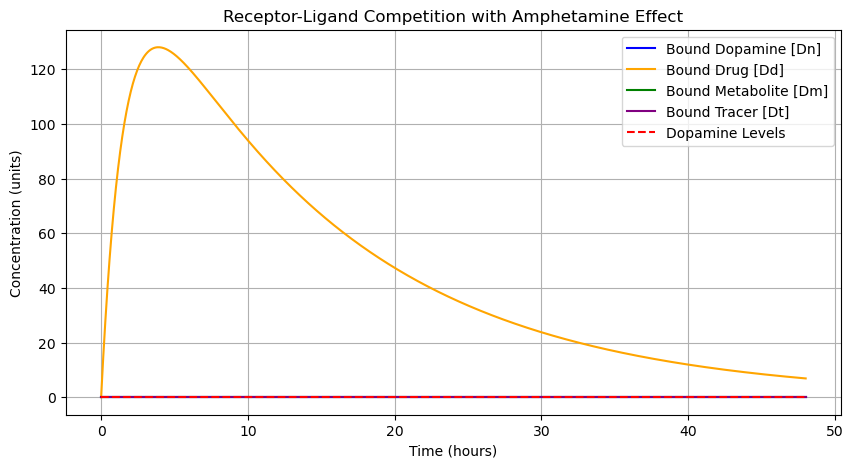

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# One-compartment pharmacokinetic (PK) model for drug concentration in plasma
def one_compartment_model(A, t, CL, V):
    """
    One-compartment model for drug concentration.
    A: Amount of drug in the system (ng)
    t: Time (hours)
    CL: Clearance (mL/h)
    V: Volume of distribution (mL)
    """
    dA_dt = -CL / V * A  # Rate of change of drug amount in the system
    return dA_dt

# Parameters
BW = 70  # Body weight (kg)
CL_per_kg = 0.257  # Clearance per kg (L/h/kg)
V_per_kg = 3.73  # Volume per kg (L/kg)

# Total clearance and volume of distribution
CL = CL_per_kg * BW * 1000  # Clearance in mL/h
V = V_per_kg * BW * 1000  # Volume in mL

# Dose in mg/kg (e.g., 0.25 mg/kg and 0.5 mg/kg)
dose_025mgkg = 0.25
dose_050mgkg = 0.5

# Convert doses to mg for a 70 kg person
dose_25mg = dose_025mgkg * BW
dose_50mg = dose_050mgkg * BW

# Convert doses to ng (1 mg = 1e6 ng)
mg2ng = 1e6
dose_25e6ng = dose_25mg * mg2ng
dose_50e6ng = dose_50mg * mg2ng

# Time points for simulation (0 to 48 hours)
t_pk = np.linspace(0, 48, 500)

# Solve the ODE for both doses (ng)
A_025_ng = odeint(one_compartment_model, dose_25e6ng, t_pk, args=(CL, V))
A_050_ng = odeint(one_compartment_model, dose_50e6ng, t_pk, args=(CL, V))

# Convert the result to concentrations (ng/mL)
C_025_ng = A_025_ng / V
C_050_ng = A_050_ng / V

# Create dataframes for plotting
df_025_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_025_ng.flatten(), 'Dose': '0.25 mg/kg'})
df_050_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_050_ng.flatten(), 'Dose': '0.50 mg/kg'})

# Combine data for both doses
combined_data_ng = pd.concat([df_025_ng, df_050_ng])

# Plot concentration over time
plt.figure(figsize=(10, 5))
for dose, group in combined_data_ng.groupby('Dose'):
    plt.plot(group['Time'], group['Concentration'], label=f'Dose {dose}')

plt.xlabel('Time (hours)')
plt.ylabel('Plasma Concentration (ng/mL)')
plt.title('One Compartment PK Model (ng/mL)')
plt.legend()
plt.grid()
plt.show()

# Verify initial concentrations
print(f"Initial concentration for 0.25 mg/kg dose: {dose_25e6ng / V} ng/mL")
print(f"Initial concentration for 0.50 mg/kg dose: {dose_50e6ng / V} ng/mL")


# Dopamine release and amphetamine effect functions
def dopamine_decay(t, last_release_time, half_life=0.1):
    """Calculate dopamine decay over time."""
    return np.exp(-np.log(2) * (t - last_release_time) / half_life)

def amphetamine_effect(amp_level, base_release, amp_release_scale, amp_reuptake_inhib, DAT_efficiency_factor):
    """
    Simulate amphetamine's effect on dopamine release and reuptake.
    amp_level: Level of amphetamine in the system
    base_release: Base dopamine release
    amp_release_scale: Increase in dopamine release due to amphetamine
    amp_reuptake_inhib: Inhibition of dopamine reuptake
    DAT_efficiency_factor: Efficiency of dopamine transporter (DAT)
    """
    amp_release = base_release * (1 + amp_release_scale * amp_level)
    amp_reuptake = amp_reuptake_inhib * amp_level * DAT_efficiency_factor
    return amp_release, amp_reuptake

# Function for receptor-ligand competition with amphetamine effect
def receptor_competition_with_amphetamine(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, 
                                          K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df, 
                                          pk_concentrations, time_points, dopamine_level, 
                                          last_release_times, amp_level, amp_release_scale, 
                                          amp_reuptake_inhib, DAT_efficiency_factor):
    """
    ODE system to model receptor competition between dopamine, drug, metabolite, and tracer.
    y: [Dn, Dd, Dm, Dt, dopamine level] - initial values of receptor-bound molecules and dopamine
    t: Time (hours)
    """
    Dn, Dd, Dm, Dt, dopamine_level = y
    
    # Interpolate current drug concentration from PK model output
    drug_concentration = np.interp(t, time_points, pk_concentrations)
    
    # Dopamine decay
    dopamine_level *= dopamine_decay(t, last_release_times[-1])

    # Amphetamine effect on dopamine release and reuptake
    base_release = 1.0
    amp_release, amp_reuptake = amphetamine_effect(amp_level, base_release, amp_release_scale, amp_reuptake_inhib, DAT_efficiency_factor)
    
    # Update dopamine level
    if t in np.arange(1, 48, 1):
        dopamine_level += amp_release
        dopamine_level -= amp_reuptake
        last_release_times.append(t)

    # Receptor-ligand binding competition
    dDn_dt = K_on_dop * dopamine_level * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug_concentration * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * 0.0 * Df - K_on_met * K_d_met * Dm  # Placeholder for metabolite concentration
    dDt_dt = K_on_tracer * 0.0 * Df - K_on_tracer * K_d_tracer * Dt  # Placeholder for tracer concentration

    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt, dopamine_level]

# Example parameters for receptor competition model (placeholders)
K_on_dop = 1.0
K_d_dop = 1.0
K_on_drug = 0.8
K_d_drug = 0.8
K_on_met = 0.6
K_d_met = 0.6
K_on_tracer = 0.4
K_d_tracer = 0.4
Df = 1.0  # Free receptor concentration

# Initial conditions: [Dn], [Dd], [Dm], [Dt], dopamine level
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]
last_release_times = [0]  # Initial release time

# Time points for ODE solution (0 to 48 hours)
t_rc = np.linspace(0, 48, 1000)

# Use PK model output for 0.50 mg/kg dose
pk_concentrations = C_050_ng.flatten()

# Amphetamine parameters
amp_release_scale = 0.5  # 50% increase in dopamine release
amp_reuptake_inhib = 0.7  # 70% reduction in dopamine reuptake
amp_level = 1.0  # Amphetamine level

DAT_efficiency_factor = 1.0  # Define DAT efficiency factor

# Solve ODE system with the correct arguments
solution_with_amp = odeint(receptor_competition_with_amphetamine, initial_conditions, t_rc,
                           args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                 K_on_tracer, K_d_tracer, Df, pk_concentrations, t_pk, 
                                 0.0, last_release_times, amp_level, amp_release_scale, 
                                 amp_reuptake_inhib, DAT_efficiency_factor))


# Extract solutions
Dn = solution_with_amp[:, 0]  # Bound dopamine
Dd = solution_with_amp[:, 1]  # Bound drug
Dm = solution_with_amp[:, 2]  # Bound metabolite
Dt = solution_with_amp[:, 3]  # Bound tracer
dopamine_levels = solution_with_amp[:, 4]  # Dopamine levels

# Print max values for each variable
print(f"Max [Dn] (Bound dopamine): {np.max(Dn)}")
print(f"Max [Dd] (Bound drug): {np.max(Dd)}")
print(f"Max [Dm] (Bound metabolite): {np.max(Dm)}")
print(f"Max [Dt] (Bound tracer): {np.max(Dt)}")
print(f"Max [Dopamine levels]: {np.max(dopamine_levels)}")

# Plot receptor competition results
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dn, label='Bound Dopamine [Dn]', color='blue')
plt.plot(t_rc, Dd, label='Bound Drug [Dd]', color='orange')
plt.plot(t_rc, Dm, label='Bound Metabolite [Dm]', color='green')
plt.plot(t_rc, Dt, label='Bound Tracer [Dt]', color='purple')
plt.plot(t_rc, dopamine_levels, label='Dopamine Levels', color='red', linestyle='dashed')

plt.xlabel('Time (hours)')
plt.ylabel('Concentration (units)')
plt.title('Receptor-Ligand Competition with Amphetamine Effect')
plt.legend()
plt.grid()
plt.show()
